In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
ticker = "NVDA"
df = yf.download(ticker, start='2025-01-01', auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [3]:
# Simple Moving Average (SMA)

def calculate_sma(df: pd.DataFrame, period: int = 20, column: str = 'Close') -> pd.Series:
    """
    Parameters:
    - df: DataFrame with price data.
    - period: window size (default 20).
    - column: yf data column to use (default 'Close').
    
    Returns:
    - Series with SMA values (NaN for the first period).

    Interpretation: price above SMA suggests uptrend; below suggests downtrend. Use for crossovers in strategies.
    """
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not in DataFrame.")
    if len(df) < period:
        raise ValueError(f"DataFrame must have at least {period} rows.")
    
    return df[column].rolling(window=period).mean()


In [4]:
# Exponential Moving Average (EMA)
# EMA gives more weights to recent prices: 
# EMA(t) = EMA(t-1) x (1-\alpha) + Price(t) x \alpha, where \alpha = 2/(Period+1). 

def calculate_ema(df: pd.DataFrame, period: int = 12, column: str = 'Close') -> pd.Series:
    """
    Parameters:
    - df: DataFrame with price data.
    - period: window size (default 12 for MACD fast line).
    - column: yf data column to use (default 'Close').
    
    Returns:
    - Series with EMA values.
    
    Interpretation: faster than SMA; use for trend confirmation. Cross above slower EMA signals buy.
    """
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not in DataFrame.")
    if len(df) < period:
        raise ValueError(f"DataFrame must have at least {period} rows.")
    
    # span=period assumes alpha = 2/(period+1) by default; to use Wilder's EMA, set decay factor alpha = 1/period
    return df[column].ewm(span=period, adjust=False).mean() # adjust=False means the exponentially weighted function is calculated recursively


In [5]:
# Weighted Moving Average (WMA)
# WMA assigns linear weights to recent prices: 
# WMA(t) = (Price(t) x t + ... + Price(1) x 1) / (t + t-1 + ... + 1). 

def calculate_wma(df: pd.DataFrame, period: int = 20, column: str = 'Close') -> pd.Series:
    """
    Parameters:
    - df: DataFrame with price data. 
    - period: window size (default 20). 
    - column: yf data column to use (default 'Close'). 
    
    Returns:
    - Series with WMA values. 

    Interpretation: more responsive than SMA; use in trending markets for early signals.
    """
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not in DataFrame.")
    if len(df) < period:
        raise ValueError(f"DataFrame must have at least {period} rows.")
    
    weights = np.arange(1, period + 1)
    def wma_func(values):
        return np.dot(values, weights) / weights.sum()
    return df[column].rolling(window=period).apply(wma_func, raw=True)


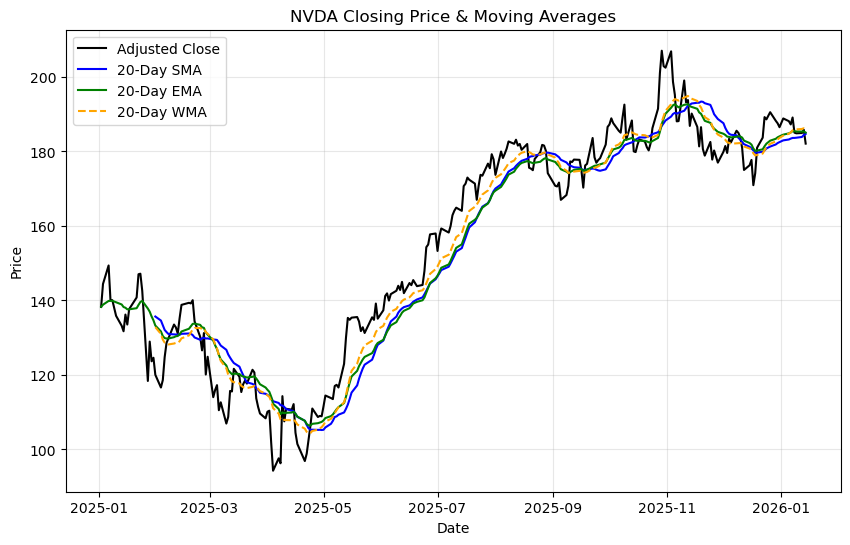

In [6]:
# Example SMA
sma_period = 20
SMA = calculate_sma(df, sma_period)

# Example EMA
ema_period = 20
EMA = calculate_ema(df, ema_period)

# Example WMA
wma_period = 20
WMA = calculate_wma(df, wma_period)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], label='Adjusted Close', color='black')
plt.plot(df.index, SMA, label=f"{sma_period}-Day SMA", color='blue', linewidth=1.5)
plt.plot(df.index, EMA, label=f"{ema_period}-Day EMA", color='green', linewidth=1.5)
plt.plot(df.index, WMA, label=f"{wma_period}-Day WMA", color='orange', linestyle='--', linewidth=1.5)
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.title(f"{ticker} Closing Price & Moving Averages")
plt.show()

In [7]:
# Average Directional Index (ADX) or Directional Movement Index (DMI)
# ADX measures trend strength. Its formula involves:
# High_diff = Current High - Previous High;
# Low_diff = Previous Low - Current Low;
# +DM = High difference if High_diff > 0 and High_diff > Low_diff, and +DM = 0 otherwise; 
# -DM = Low_diff if Low_diff > 0 and Low_diff > High_diff, and -DM = 0 otherwise; 
# True Range (TR) = Max{Current High - Current Low, |Current High - Previous Close|, |Current Low - Previous Close|};
# Average True Range (ATR) = EMA of TR, or ATR(t) = (ATR(t-1) x (n-1) + TR(t)) / n for a different choice of alpha according to Wikipedia;
# +DI = 100 x EMA(+DM) / ATR;
# -DI = 100 x EMA(-DM) / ATR;
# DX = 100 x |+DI - -DI| / (+DI + -DI);
# ADX = EMA of DX.

def calculate_adx(df: pd.DataFrame, period: int = 14) -> pd.DataFrame:
    """
     Parameters:
    - df: DataFrame with 'High', 'Low', 'Close'.
    - period: window size (default 14).
    
    Returns:
    - DataFrame with 'plus_di', 'minus_di', 'adx'.
    
    Interpretation: ADX >25 = strong trend; +DI > -DI = uptrend. Use to filter oscillators.
    """
    required_cols = ['High', 'Low', 'Close']
    if not all(col in df.columns for col in required_cols):
        raise ValueError("DataFrame missing required columns: High, Low, Close.")
    if len(df) < period * 2:
        raise ValueError(f"DataFrame must have at least {period * 2} rows.")
    
    high_diff = df['High'].diff()
    low_diff = -df['Low'].diff()
    plus_dm = high_diff.where((high_diff > low_diff) & (high_diff > 0), 0)
    minus_dm = low_diff.where((low_diff > high_diff) & (low_diff > 0), 0)
    tr = np.maximum(df['High'] - df['Low'], np.maximum(abs(df['High'] - df['Close'].shift()), abs(df['Low'] - df['Close'].shift())))
    atr = tr.ewm(span=period, adjust=False).mean()
    plus_di = 100 * (plus_dm.ewm(span=period, adjust=False).mean() / atr)
    minus_di = 100 * (minus_dm.ewm(span=period, adjust=False).mean() / atr)
    dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)
    adx = dx.ewm(span=period, adjust=False).mean()
    return pd.DataFrame({'plus_di': plus_di.values.flatten(), 'minus_di': minus_di.values.flatten(), 'adx': adx.values.flatten()}, index=df.index)


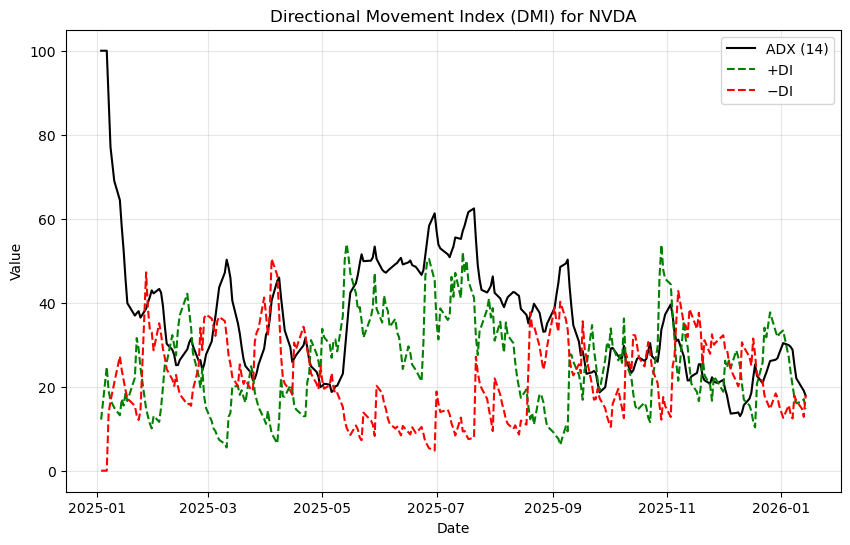

In [8]:
# Example DMI

dmi_period = 14
DMI = calculate_adx(df, dmi_period)

plt.figure(figsize=(10, 6))
plt.plot(df.index, DMI['adx'], label=f'ADX ({dmi_period})', color='black', linewidth=1.5)
plt.plot(df.index, DMI['plus_di'], label='$+$DI', color='green', linestyle='--')
plt.plot(df.index, DMI['minus_di'], label='$-$DI', color='red', linestyle='--')
plt.ylabel('Value')
plt.xlabel('Date')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.title(f'Directional Movement Index (DMI) for {ticker}')
plt.show()

In [9]:
# Aroon Indicator
# The indicator measures time since highs/lows. It is also a useful tool for identifying periods of consolidation.
# Aroon-Up = ((period - days since period high) / period) x 100
# Aroon-Down = ((period - days since period low) / period) x 100
# These numbers are intended to quantify the strength of a trend. The closer the number is to 100, the stronger the trend.

def calculate_aroon(df: pd.DataFrame, period: int = 14) -> pd.DataFrame:
    """    
    Parameters:
    - df: DataFrame with 'High', 'Low'.
    - period: window size (default 14).
    
    Returns:
    - DataFrame with 'aroon_up', 'aroon_down'.
    
    Interpretation: Up > Down and Up >50 = strong uptrend.
    """
    required_cols = ['High', 'Low']
    if not all(col in df.columns for col in required_cols):
        raise ValueError("DataFrame missing required columns.")
    if len(df) < period + 1:
        raise ValueError(f"DataFrame must have at least {period + 1} rows.")
    
    def aroon_up(high):
        return 100 * (period - (period - high.argmax())) / period
    def aroon_down(low):
        return 100 * (period - (period - low.argmin())) / period
    
    a_up = df['High'].rolling(window=period+1).apply(aroon_up, raw=False)
    a_down = df['Low'].rolling(window=period+1).apply(aroon_down, raw=False)
    return pd.DataFrame({'aroon_up': a_up.values.flatten(), 'aroon_down': a_down.values.flatten()}, index=df.index)

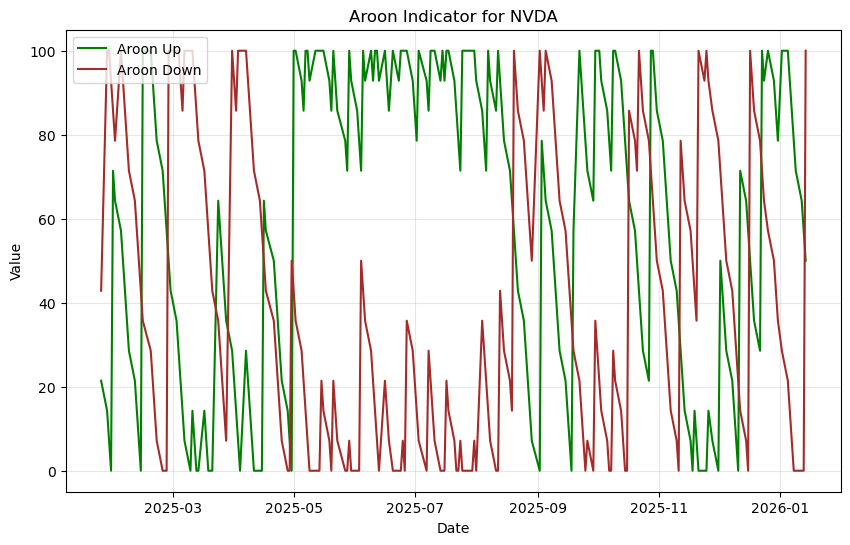

In [10]:
# Example (Aroon)

aroon_period = 14
AROON = calculate_aroon(df, aroon_period)

plt.figure(figsize=(10, 6))
plt.plot(df.index, AROON['aroon_up'], label='Aroon Up', color='green')
plt.plot(df.index, AROON['aroon_down'], label='Aroon Down', color='brown')
plt.ylabel('Value')
plt.ylim(-5, 105)
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.title(f'Aroon Indicator for {ticker}')
plt.show()